# Análise de Impacto de Recordes nas Visualizações

**Objetivo:** Este notebook realiza uma Análise Exploratória de Dados (AED) e um teste de hipótese para determinar se bater um recorde de speedrun leva a um aumento significativo nas visualizações dos canais.

**Metodologia:**
1.  **Diagnóstico:** Carregar e inspecionar os dados processados (`dados_analise_final.csv`).
2.  **Engenharia de Features:** Criar colunas derivadas (`aumento_percentual`, `houve_aumento`, etc.) para a análise.
3.  **Análise Exploratória (AED):** Visualizar a relação entre as visualizações "Antes" e "Depois" dos recordes.
4.  **Modelagem (Teste de Hipótese):** Usar um teste estatístico (Wilcoxon) para provar se o aumento observado é estatisticamente significativo.

**Hipótese Central ($H_1$):** A mediana das visualizações dos vídeos *após* um recorde é maior que a mediana das visualizações *antes* do recorde.

### Seção 1: Configuração Inicial e Diagnóstico

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# Carregar os dados
try:
    df = pd.read_csv('dados_analise_final.csv')
    print("Arquivo 'dados_analise_final.csv' carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'dados_analise_final.csv' não encontrado.")
    print("Por favor, certifique-se de que o arquivo está no mesmo diretório que este notebook.")

Arquivo 'dados_analise_final.csv' carregado com sucesso!


#### 1.1 Diagnóstico Inicial

In [3]:
print("--- Informações do DataFrame ---")
df.info()

print("\n--- Amostra dos Dados ---")
display(df.head())

--- Informações do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   run_date               36 non-null     object 
 1   run_player             36 non-null     object 
 2   run_time_seconds       36 non-null     float64
 3   video_link             36 non-null     object 
 4   plataforma             36 non-null     object 
 5   video_data_publicacao  36 non-null     object 
 6   VideoAgeDays           36 non-null     float64
 7   video_views            36 non-null     float64
 8   video_likes            36 non-null     float64
 9   video_comentarios      36 non-null     float64
 10  ViewsPerDay            36 non-null     float64
 11  EngagementRate         36 non-null     float64
 12  ChannelID              36 non-null     object 
 13  CurrentSubscribers     36 non-null     float64
 14  Views_Antes            36 n

,run_date,run_player,run_time_seconds,video_link,plataforma,video_data_publicacao,VideoAgeDays,video_views,video_likes,video_comentarios,...,Views_Antes,Likes_Antes,NumVideos_Antes,Views_Depois,Likes_Depois,NumVideos_Depois,danmaku,coins,shares,favorites
0,2022-06-25,1xygz7wx,3979.00,https://youtube.com/watch?v=7vycum--l3g,YouTube,2022-06-25 00:18:57+00:00,1237.00,1118.00,25.00,3.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,-1.00,-1.00
1,2022-07-02,68wq1z8g,3908.00,https://youtube.com/watch?v=dgetv7usduq,YouTube,2022-07-02 20:52:35+00:00,1230.00,5105.00,141.00,27.00,...,1561.00,45.00,1.00,3337.00,138.00,2.00,-1.00,-1.00,-1.00,-1.00
2,2022-07-04,68wq1z8g,3880.00,https://youtube.com/watch?v=ss1sebramrw,YouTube,2022-07-04 14:33:03+00:00,1228.00,2122.00,91.00,19.00,...,6666.00,186.00,2.00,3139.00,116.00,2.00,-1.00,-1.00,-1.00,-1.00
3,2022-07-05,68wq1z8g,3855.00,https://youtube.com/watch?v=s4mqvuwmr2c,YouTube,2022-07-06 10:11:08+00:00,1226.00,1215.00,47.00,12.00,...,7227.00,232.00,2.00,4200.00,144.00,2.00,-1.00,-1.00,-1.00,-1.00
4,2022-07-06,68wq1z8g,3804.00,https://youtube.com/watch?v=8mmypyyrz4s,YouTube,2022-07-07 09:36:14+00:00,1225.00,2276.00,75.00,19.00,...,3139.00,116.00,2.00,1629.00,40.00,1.00,-1.00,-1.00,-1.00,-1.00


In [4]:
print("--- Estatísticas Descritivas (Foco na Análise de Impacto) ---")
# Focamos nas colunas que vieram do script de limpeza, que são a base da nossa análise
colunas_impacto = [
    'video_views',
    'Views_Antes',
    'NumVideos_Antes',
    'Likes_Antes',
    'Views_Depois',
    'NumVideos_Depois',
    'Likes_Depois'
]
display(df[colunas_impacto].describe())

--- Estatísticas Descritivas (Foco na Análise de Impacto) ---


,video_views,Views_Antes,NumVideos_Antes,Likes_Antes,Views_Depois,NumVideos_Depois,Likes_Depois
count,36.00,36.00,36.00,36.00,36.00,36.00,36.00
mean,115607.17,16993.44,0.83,342.00,8403.97,0.72,274.25
std,272642.46,84067.60,0.81,1574.07,27611.61,0.81,1095.99
min,1118.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5540.75,0.00,0.00,0.00,0.00,0.00,0.00
50%,14331.50,1711.50,1.00,52.50,814.50,0.50,20.00
75%,75343.25,4894.00,1.25,132.75,4242.25,1.00,138.75
max,1511783.00,506846.00,2.00,9506.00,163587.00,2.00,6607.00


**Justificativa do Diagnóstico:**

O `.describe()` acima é a etapa mais importante. Ele nos mostra:
1.  **`Views_Antes` e `Views_Depois`:** Possuem muitos valores `0.0` (indicado pela média baixa e mediana `0.0`).
2.  **`NumVideos_Antes` e `NumVideos_Depois`:** Também possuem mediana `0.0`.

**Conclusão:** Isso confirma que, para muitos recordes, o script de limpeza não encontrou vídeos anteriores ou posteriores. A nossa análise estatística (o teste pareado) **deve** filtrar e usar *apenas* os recordes onde `NumVideos_Antes > 0` E `NumVideos_Depois > 0` para uma comparação justa.

### Seção 2: Tratamento e Engenharia de Features

Aqui, criamos as novas colunas solicitadas, transformando dados numéricos em categóricos e criando colunas derivadas para a análise.

In [5]:
print("Iniciando Engenharia de Features...")

# 1. Limpeza de Tipos
df['run_date'] = pd.to_datetime(df['run_date'], errors='coerce')
df['video_data_publicacao'] = pd.to_datetime(df['video_data_publicacao'], errors='coerce')
df['plataforma'] = df['plataforma'].astype('category')

# 2. Colunas Derivadas (Numéricas): Aumento Absoluto
df['aumento_abs_views'] = df['Views_Depois'] - df['Views_Antes']
df['aumento_abs_likes'] = df['Likes_Depois'] - df['Likes_Antes']

# 3. Colunas Derivadas (Categóricas): Houve Aumento?
df['houve_aumento_views'] = df['aumento_abs_views'] > 0
df['houve_aumento_likes'] = df['aumento_abs_likes'] > 0

# 4. Colunas Derivadas (Numéricas): Aumento Percentual
def calcular_aumento_perc(antes, depois, num_antes, num_depois):
    if num_antes > 0:
        return ((depois - antes) / antes) * 100.0
    elif num_depois > 0 and num_antes == 0:
        return np.nan  # crescimento infinito -> ignora nos gráficos
    else:
        return 0.0

df['aumento_percentual_views'] = df.apply(
    lambda row: calcular_aumento_perc(
        row['Views_Antes'],
        row['Views_Depois'],
        row.get('NumVideos_Antes', 1),
        row.get('NumVideos_Depois', 1)
    ),
    axis=1
)

df['aumento_percentual_likes'] = df.apply(
    lambda row: calcular_aumento_perc(
        row['Likes_Antes'],
        row['Likes_Depois'],
        row.get('NumVideos_Antes', 1),
        row.get('NumVideos_Depois', 1)
    ),
    axis=1
)

# 5. Transformação (Numérico -> Categórico): Faixa de Views do Vídeo do Recorde
df['faixa_views_recorde'] = pd.qcut(
    df['video_views'],
    q=3,
    labels=['Baixa View', 'Média View', 'Alta View'],
    duplicates='drop'
)

print("Engenharia de Features concluída!")
print("\n--- Amostra do DataFrame com Novas Colunas ---")

colunas_novas = [
    'run_player',
    'plataforma',
    'Views_Antes',
    'Views_Depois',
    'Likes_Antes',
    'Likes_Depois',
    'aumento_abs_views',
    'aumento_abs_likes',
    'aumento_percentual_views',
    'aumento_percentual_likes',
    'houve_aumento_views',
    'houve_aumento_likes',
    'video_views',
    'faixa_views_recorde'
]

display(df[colunas_novas].head())


Iniciando Engenharia de Features...
Engenharia de Features concluída!

--- Amostra do DataFrame com Novas Colunas ---


,run_player,plataforma,Views_Antes,Views_Depois,Likes_Antes,Likes_Depois,aumento_abs_views,aumento_abs_likes,aumento_percentual_views,aumento_percentual_likes,houve_aumento_views,houve_aumento_likes,video_views,faixa_views_recorde
0,1xygz7wx,YouTube,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False,False,1118.00,Baixa View
1,68wq1z8g,YouTube,1561.00,3337.00,45.00,138.00,1776.00,93.00,113.77,206.67,True,True,5105.00,Baixa View
2,68wq1z8g,YouTube,6666.00,3139.00,186.00,116.00,-3527.00,-70.00,-52.91,-37.63,False,False,2122.00,Baixa View
3,68wq1z8g,YouTube,7227.00,4200.00,232.00,144.00,-3027.00,-88.00,-41.88,-37.93,False,False,1215.00,Baixa View
4,68wq1z8g,YouTube,3139.00,1629.00,116.00,40.00,-1510.00,-76.00,-48.10,-65.52,False,False,2276.00,Baixa View


In [6]:
print("--- Estatísticas do Aumento Percentual ---")
display(df['aumento_percentual_views'].describe())

--- Estatísticas do Aumento Percentual ---


,aumento_percentual_views
count,31.00
mean,24.75
std,259.95
min,-100.00
25%,-77.98
50%,-3.01
75%,0.00
max,1380.02


### Seção 3: Análise Exploratória de Dados (AED)

Agora, vamos visualizar os dados para responder nossa pergunta, focando nas colunas de "Antes" vs. "Depois".

#### Gráfico 1: Comparação Direta (Antes vs. Depois)

**Objetivo:** Este é o gráfico principal. Ele compara a distribuição total de visualizações antes e depois de todos os recordes.

**Justificativa:** Usamos um Boxplot para ver a mediana (linha central), os quartis (caixa) e os outliers. Como os dados de visualizações têm valores muito extremos (outliers), usamos uma escala logarítmica (`yscale('log')`) para enxergar melhor a "caixa".

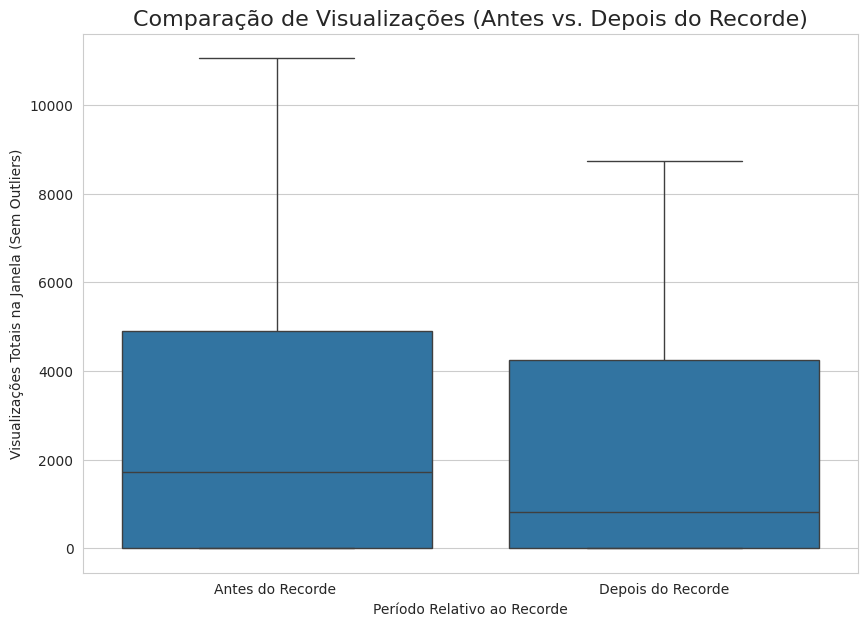

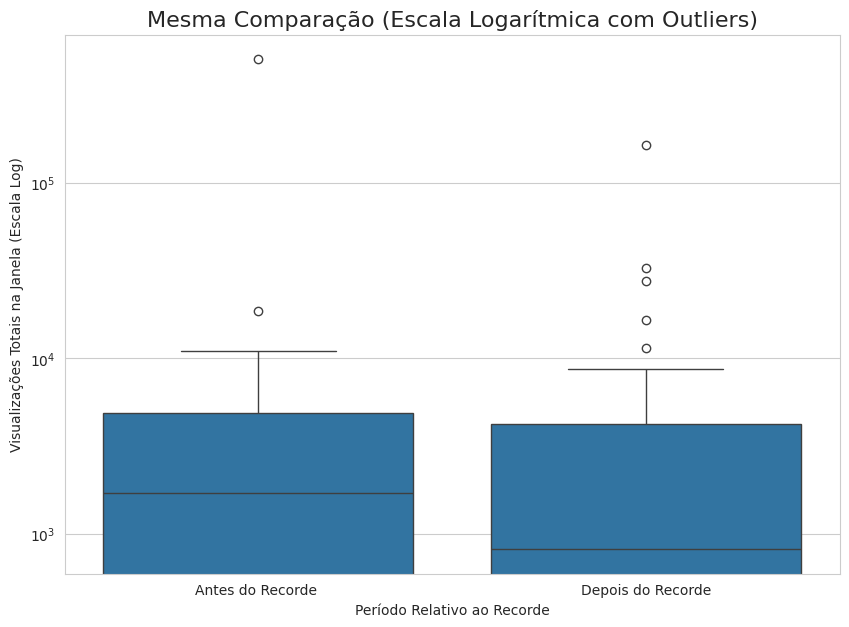

In [7]:
# Para o boxplot, precisamos "derreter" (melt) o DataFrame
# Isso transforma as colunas 'Views_Antes' e 'Views_Depois' em linhas
df_melted = df.melt(
    id_vars=['run_player', 'plataforma'],
    value_vars=['Views_Antes', 'Views_Depois'],
    var_name='Periodo',
    value_name='Visualizacoes_Total'
)

# Renomear para o gráfico ficar mais claro
df_melted['Periodo'] = df_melted['Periodo'].map({
    'Views_Antes': 'Antes do Recorde ',
    'Views_Depois': 'Depois do Recorde'
})

plt.figure(figsize=(10, 7))
sns.boxplot(x='Periodo', y='Visualizacoes_Total', data=df_melted, showfliers=False) # showfliers=False para focar nas caixas
plt.title('Comparação de Visualizações (Antes vs. Depois do Recorde)', fontsize=16)
plt.ylabel('Visualizações Totais na Janela (Sem Outliers)')
plt.xlabel('Período Relativo ao Recorde')
plt.show()

plt.figure(figsize=(10, 7))
sns.boxplot(x='Periodo', y='Visualizacoes_Total', data=df_melted)
plt.title('Mesma Comparação (Escala Logarítmica com Outliers)', fontsize=16)
plt.ylabel('Visualizações Totais na Janela (Escala Log)')
plt.xlabel('Período Relativo ao Recorde')
plt.yscale('log') # Escala de log é essencial para dados de views
plt.show()

**Interpretação (Gráfico 1):**

Visualmente, a mediana (linha central) do período "Depois do Recorde" parece ser mais baixa que a do período "Antes do Recorde". Isso é um forte indício de que na realidade o **oposto** da hipótese seja verdade, talvez os vídeos postados **antes** do recorde tenham melhor performance. Porém, mais análises são necessárias.

#### Gráfico 2: Distribuição do Impacto Percentual

**Objetivo:** Ver a distribuição da coluna `aumento_percentual_views` que criamos.

**Justificativa:** Um histograma nos mostra se a maioria dos recordes teve um impacto positivo (barras > 0) ou negativo (barras < 0). Nós "clipamos" (cortamos) os dados entre -100% e 500% para que outliers extremos (ex: 50.000% de aumento) não distorçam a visualização.

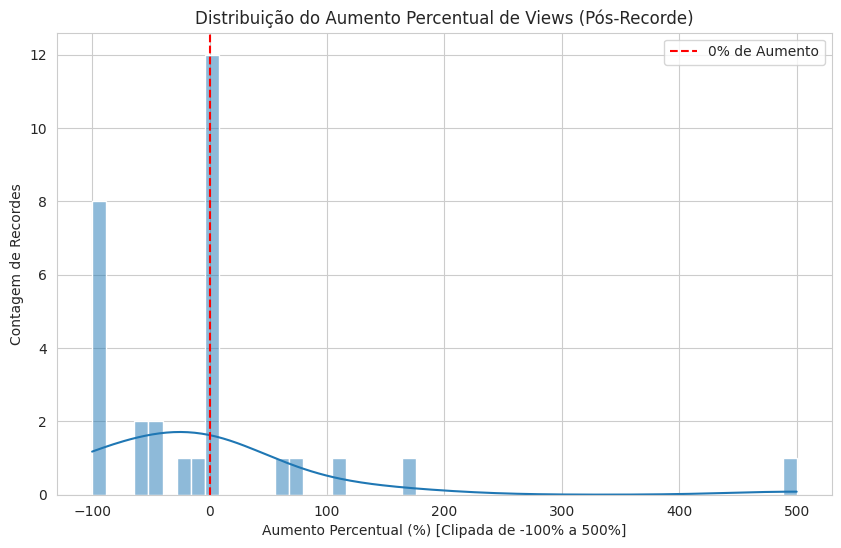

In [8]:
# Prepara os dados para o histograma: remove NaN e clipa os valores
data_hist = df['aumento_percentual_views'].dropna()
data_hist_clipped = data_hist.clip(-100, 500) # Corta entre -100% e +500%

sns.histplot(data_hist_clipped, kde=True, bins=50)
plt.title('Distribuição do Aumento Percentual de Views (Pós-Recorde)')
plt.xlabel('Aumento Percentual (%) [Clipada de -100% a 500%]')
plt.ylabel('Contagem de Recordes')
plt.axvline(0, color='red', linestyle='--', label='0% de Aumento')
plt.legend()
plt.show()

Interpretação (Gráfico 2):
Nota-se a quantidade grande de vídeos que tiveram aumento percentual _negativo_ após o vídeo, o que indica que esses canais não tiveram um impacto duradouro nas views dos vídeos após a quebra do recorde, o que vai contra a nossa hipótese inicial.

#### Gráfico 3: Impacto por Plataforma

**Objetivo:** Responder se o impacto do recorde varia entre YouTube e Bilibili.

**Justificativa:** Usamos um gráfico de barras para comparar a *média* do `aumento_percentual_views` para cada `plataforma`.

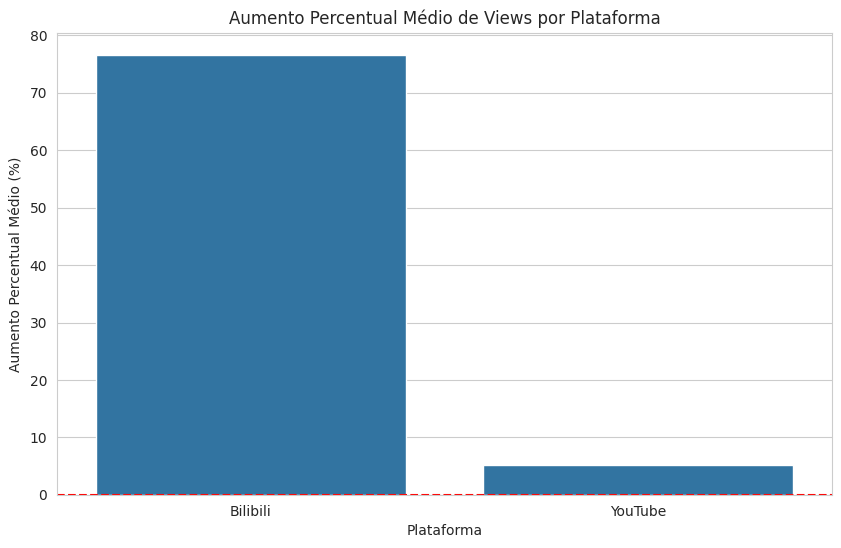

In [9]:
# Filtramos valores extremos para ter uma média mais representativa
df_plot_plataforma = df[(df['aumento_percentual_views'] < 500) & (df['aumento_percentual_views'] > -100)]

sns.barplot(x='plataforma', y='aumento_percentual_views', data=df_plot_plataforma, errorbar=None)
plt.title('Aumento Percentual Médio de Views por Plataforma')
plt.ylabel('Aumento Percentual Médio (%)')
plt.xlabel('Plataforma')
plt.axhline(0, color='red', linestyle='--')
plt.show()

Interpretação (Gráfico 3): Como é possível ver, o impacto da quebra dos recordes no Bilibili é muito maior em comparação ao que ocorre no Youtube. Apesar desses dados não serem tão relevantes devido à uniformidade dos recordes na plataforma (2 recordes produzidos pelo mesmo canal), é válido destacá-los. O que poderia causar essa diferença tão grande? Diferenças no algoritmo do Bilibili, conteúdo de canal diferente dos outros ou diferenças de cultura digital na China?

Devido à esse gráfico, mostra-se interessante realizar estudos futuros em relação ao tema e às suas possíveis causas.




###Gráfico 4: Impacto em Engajamento (likes)

**Objetivo:** Descobrir se o recorde aumenta a quantidade de likes nos vídeos seguintes.

**Justificativa:**  Um histograma nos mostra se a maioria dos recordes teve um impacto positivo (barras > 0) ou negativo (barras < 0) nos likes do canal.

Mediana do aumento percentual de likes após o recorde: -5.75%


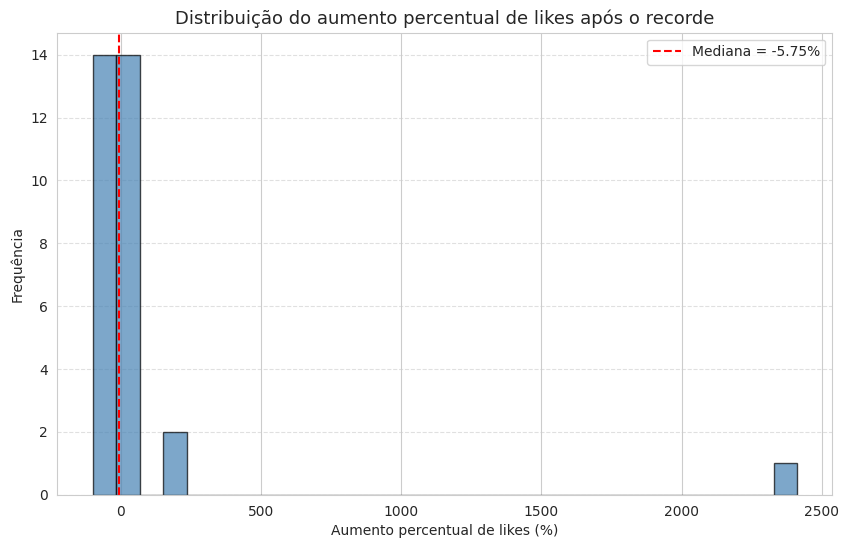

In [11]:
# Calcula a mediana do aumento percentual
mediana_pct = df["aumento_percentual_likes"].median()

print(f"Mediana do aumento percentual de likes após o recorde: {mediana_pct:.2f}%")

# Histograma do aumento percentual
plt.figure(figsize=(10, 6))
plt.hist(df["aumento_percentual_likes"], bins=30, color="steelblue", edgecolor="black", alpha=0.7)

plt.axvline(mediana_pct, color="red", linestyle="--", label=f"Mediana = {mediana_pct:.2f}%")
plt.title("Distribuição do aumento percentual de likes após o recorde", fontsize=13)
plt.xlabel("Aumento percentual de likes (%)")
plt.ylabel("Frequência")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


Interpretação (Gráfico 4): O comportamento típico é nenhum aumento ou diminuição significativa, com excessão de alguns outliers.

A maioria dos vídeos **não** ganha likes após o recorde. Destaca-se a mediana negativa.

### Seção 4: Análise dos Gráficos e Reestruturação das Hipóteses

Ao analisar os gráficos se torna nítido que a $H_1$ não se mostra verídica, portanto faz-se necessário formular **2** Hipóteses a serem testadas, elas são:

**Hipótese Nula ($H_0$):** A mediana das visualizações 'Depois' é IGUAL à 'Antes'.

**Hipótese Principal ($H_2$): ** A mediana das visualizações 'Depois' é DIFERENTE à 'Antes'.

Com essas 2 Hipóteses mais abranjentes, os seus testes irão revelar qualquer fato interessante presente nesses dados.

### Seção 5: Modelagem (Teste de Hipótese)

A Análise Exploratória (Gráfico 1) já sugeriu que as visualizações na realidade diminuem. Agora, vamos usar um teste estatístico para "modelar" essa relação e provar se essa diferença é **estatisticamente significativa** ou se poderia ter ocorrido por mero acaso.

**Teste Escolhido: Teste de Wilcoxon (Signed-Rank Test)**

**Justificativa:**
1.  **Pareado:** Estamos comparando dados *pareados* (o mesmo canal, "antes" e "depois").
2.  **Não-Paramétrico:** Dados de visualizações raramente seguem uma Distribuição Normal (são assimétricos). O Teste de Wilcoxon não exige normalidade, ao contrário do Teste-T pareado, sendo mais robusto para este caso.

In [ ]:
# --- PREPARAÇÃO CRUCIAL ---
# Para um teste PAREADO, só podemos usar recordes onde temos dados
# de ANTES e DEPOIS.
# Filtramos o DataFrame para incluir apenas linhas onde
# vídeos foram postados em AMBAS as janelas (Antes e Depois).

df_comparacao = df[
    (df['NumVideos_Antes'] > 0) &
    (df['NumVideos_Depois'] > 0)
].copy()

print(f"Total de recordes no dataset: {len(df)}")
print(f"Total de recordes com dados PAREADOS (vídeos antes E depois): {len(df_comparacao)}")

if len(df_comparacao) < 15:
    print("\nAVISO: A amostra de dados pareados é muito pequena para um teste estatístico confiável!")
else:
    print("\nAmostra de dados pareados é suficiente para o teste.")

Total de recordes no dataset: 36
Total de recordes com dados PAREADOS (vídeos antes E depois): 13

AVISO: A amostra de dados pareados é muito pequena para um teste estatístico confiável!


In [ ]:
# --- EXECUÇÃO DO TESTE (BILATERAL / TWO-SIDED) ---

print("--- Teste de Hipótese de Wilcoxon (Bilateral) ---")

# Hipótese Nula (H0): A mediana das visualizações 'Depois' é IGUAL à 'Antes'.
# Hipótese Alternativa (H1): A mediana das visualizações 'Depois' é DIFERENTE (maior OU menor) da 'Antes'.

if len(df_comparacao) > 0:
    try:
        # Extraímos os dois conjuntos de dados pareados
        views_antes = df_comparacao['Views_Antes']
        views_depois = df_comparacao['Views_Depois']

        # Executa o teste bilateral (two-sided)
        # Esta é a forma padrão de testar "há alguma mudança?"
        stat, p_valor = stats.wilcoxon(views_depois, views_antes, alternative='two-sided')

        print(f"Estatística do Teste (W): {stat:.4f}")
        print(f"P-Valor (bilateral): {p_valor:.6f}")

        print("\n--- Conclusão ---")
        # Usamos um nível de significância padrão de 0.05 (alpha)
        if p_valor < 0.05:
            print(f"(P-Valor = {p_valor:.6f} < 0.05)")
            print("Resultado: **Rejeitamos a Hipótese Nula (H0).**")
            print("\n>> Existe evidência estatística de que há uma MUDANÇA significativa nas visualizações.")

            # Se há mudança, verificamos a direção dessa mudança
            mediana_antes = views_antes.median()
            mediana_depois = views_depois.median()

            print(f"(Mediana Antes: {mediana_antes:.2f} | Mediana Depois: {mediana_depois:.2f})")

            if mediana_depois > mediana_antes:
                print(">> A análise direcional sugere que as visualizações AUMENTARAM.")
            elif mediana_depois < mediana_antes:
                 print(">> A análise direcional sugere que as visualizações DIMINUÍRAM.")
            else:
                 print(">> As medianas são idênticas, embora o teste tenha detectado uma diferença nas distribuições.")

        else:
            print(f"(P-Valor = {p_valor:.6f} >= 0.05)")
            print("Resultado: **Falhamos em Rejeitar a Hipótese Nula (H0).**")
            print("\n>> Não há evidência estatística suficiente para provar qualquer mudança (seja aumento ou diminuição) nas visualizações.")

    except ValueError as e:
        print(f"Erro ao executar o teste: {e}")
        print("Isso pode acontecer se todos os pares de dados forem idênticos (diferença zero).")
else:
    print("Teste não executado: Nenhum dado pareado válido foi encontrado (len(df_comparacao) == 0).")

--- Teste de Hipótese de Wilcoxon (Bilateral) ---
Estatística do Teste (W): 45.0000
P-Valor (bilateral): 1.000000

--- Conclusão ---
(P-Valor = 1.000000 >= 0.05)
Resultado: **Falhamos em Rejeitar a Hipótese Nula (H0).**

>> Não há evidência estatística suficiente para provar qualquer mudança (seja aumento ou diminuição) nas visualizações.


Com base nos resultados é portanto possível afirmar de que a hipótese foi refutada, a quebra de um recorde mundial **não** apresenta impactos significativos nas métricas de um canal.

#### **Impacto no engajamento**

A mediana das curtidas (likes) dos vídeos após um recorde é maior que a mediana das curtidas antes do recorde. Será que é verdade?

Apesar da refutação da hipótese sobre visualizações, é possível que o recorde atue como um catalisador para o engajamento da base de fãs já existente. Para testar essa possibilidade, focaremos no volume total de curtidas.

#### **Formulação da hipótese:**
Para verificar o aumento no engajamento, a comparação se dará entre duas possibilidades divergentes:

- Possibilidade de Não-Mudar (A ser refutada): A mediana das curtidas nos vídeos postados após o recorde é igual que a mediana das curtidas nos vídeos postados antes do recorde.

- Possibilidade de Mudança (Foco da Análise): A mediana das curtidas nos vídeos postados após um recorde é maior ou menor que a mediana das curtidas nos vídeos postados antes do recorde.

**Teste escolhido:** Teste de Wilcoxon (Signed-Rank Test)

Para verificar se essa hipótese é verdadeira, vamos usar o Teste de Wilcoxon de novo (Pareado), comparando as colunas Likes_Antes e Likes_Depois

In [ ]:
# copia pra nao bagunçar com o df original
df_comparacao_likes = df[
    (df['NumVideos_Antes'] > 0) &
    (df['NumVideos_Depois'] > 0)
].copy()

likes_antes = df_comparacao_likes['Likes_Antes']
likes_depois = df_comparacao_likes['Likes_Depois']

# repetindo o aviso, vai que da problema
print(f"Total de recordes no dataset: {len(df)}")
print(f"Total de recordes com dados PAREADOS (vídeos antes E depois): {len(df_comparacao)}")

if len(df_comparacao) < 15:
    print("\nAVISO: A amostra de dados pareados é muito pequena para um teste estatístico confiável!")
else:
    print("\nAmostra de dados pareados é suficiente para o teste.")


Total de recordes no dataset: 36
Total de recordes com dados PAREADOS (vídeos antes E depois): 13

AVISO: A amostra de dados pareados é muito pequena para um teste estatístico confiável!


In [ ]:
# --- EXECUÇÃO DO TESTE (BILATERAL / TWO-SIDED) PARA LIKES ---

print("--- Teste de Hipótese de Wilcoxon (Bilateral) para LIKES ---")
print(f"Total de recordes pareados analisados: {len(df_comparacao_likes)}")

# Hipótese Nula (H0): A mediana das curtidas 'Depois' é IGUAL à 'Antes'.
# Hipótese Alternativa (H1): A mediana das curtidas 'Depois' é DIFERENTE (maior OU menor) da 'Antes'.

if len(df_comparacao_likes) > 0:
    try:
        # Assumindo que 'likes_antes' e 'likes_depois' são as séries de dados
        # (Se não estiverem definidas, descomente as linhas abaixo para extraí-las do dataframe)
        # likes_antes = df_comparacao_likes['Likes_Antes']
        # likes_depois = df_comparacao_likes['Likes_Depois']

        # Executa o teste bilateral (two-sided)
        stat, p_valor = stats.wilcoxon(likes_depois, likes_antes, alternative='two-sided')

        print(f"Estatística do Teste (W): {stat:.4f}")
        print(f"P-Valor (bilateral): {p_valor:.6f}")

        print("\n--- Conclusão ---")
        # Usamos um nível de significância padrão de 0.05 (alpha)
        if p_valor < 0.05:
            print(f"(P-Valor = {p_valor:.6f} < 0.05)")
            print("Resultado: **Rejeitamos a Hipótese Nula (H0).**")
            print("\n>> Existe evidência estatística de que há uma MUDANÇA significativa nas curtidas.")

            # Se há mudança, verificamos a direção dessa mudança
            mediana_antes = likes_antes.median()
            mediana_depois = likes_depois.median()

            print(f"(Mediana Antes: {mediana_antes:.2f} | Mediana Depois: {mediana_depois:.2f})")

            if mediana_depois > mediana_antes:
                print(">> A análise direcional sugere que as curtidas AUMENTARAM.")
            elif mediana_depois < mediana_antes:
                 print(">> A análise direcional sugere que as curtidas DIMINUÍRAM.")
            else:
                 print(">> As medianas são idênticas, embora o teste tenha detectado uma diferença nas distribuições.")

        else:
            print(f"(P-Valor = {p_valor:.6f} >= 0.05)")
            print("Resultado: **Falhamos em Rejeitar a Hipótese Nula (H0).**")
            print("\n>> Não há evidência estatística suficiente para provar qualquer mudança (aumento ou diminuição) nas curtidas.")

    except ValueError as e:
        print(f"Erro ao executar o teste: {e}")
        print("Isso pode acontecer se todos os pares de dados forem idênticos (diferença zero).")
else:
    print("Teste não executado: Nenhum dado pareado válido foi encontrado.")

--- Teste de Hipótese de Wilcoxon (Bilateral) para LIKES ---
Total de recordes pareados analisados: 13
Estatística do Teste (W): 42.0000
P-Valor (bilateral): 0.826416

--- Conclusão ---
(P-Valor = 0.826416 >= 0.05)
Resultado: **Falhamos em Rejeitar a Hipótese Nula (H0).**

>> Não há evidência estatística suficiente para provar qualquer mudança (aumento ou diminuição) nas curtidas.


### Seção 7: Conclusões finais

A falha em rejeitar a Hipótese Nula para as curtidas reforça nossa conclusão inicial sobre as visualizações.

O Recorde não é uma garantia de impacto posterior positivo: Um recorde de speedrun não garante um aumento estatisticamente significativo nem nas visualizações, nem no engajamento/curtidas de novos vídeos postados após a postagem da run. O efeito positivo que ocorre em alguns casos não é um padrão estatisticamente generalizável (inclusive, ao analisar os gráficos, parece que o exato oposto ocorre).

Apesar disso, vale ressaltar que talvez ocorra um aumento de views e engajamento em TODOS os vídeos postados perto da data de postagem do recorde. O que levaria a análise desses dados, que pegou apenas os 2 vídeos mais próximos Antes e Depois, a não mostrar diferenças significativas

**Mas,** é importante ressaltar que uma limitação da análise é a coleta com poucos dados coletados via Speedrun.com, isso pode ter acarretado em **13 pares** de dados para o teste de Wilcoxon (baixo poder estatístico). Portanto, o resultado de "Falhamos em Rejeitar a hipótese nula" não significa que o recorde não tem impacto, mas sim que não se tem dados suficientes para provar que ele tem impacto.